In [1]:
import os
import sys
sys.path.append(os.path.abspath("/users/amtseng/tfmodisco/src/"))
sys.path.append(os.path.abspath("/users/amtseng/tfmodisco/notebooks/reports/"))
from feature.util import one_hot_to_seq
from tfmodisco.run_tfmodisco import import_shap_scores
from motif.read_motifs import trim_motif_by_ic, pfm_to_pwm
import plot.viz_sequence as viz_sequence
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager

In [2]:
# Plotting defaults
font_manager.fontManager.ttflist.extend(
    font_manager.createFontList(
        font_manager.findSystemFonts(fontpaths="/users/amtseng/modules/fonts")
    )
)
plot_params = {
    "figure.titlesize": 22,
    "axes.titlesize": 22,
    "axes.labelsize": 20,
    "legend.fontsize": 18,
    "font.size": 13,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "font.family": "Roboto",
    "font.weight": "bold"
}
plt.rcParams.update(plot_params)

/users/amtseng/miniconda3/envs/tfmodisco-mini/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  after removing the cwd from sys.path.


### Define constants and paths

In [3]:
# Define parameters/fetch arguments
tf_name = "SPI1"
head = "profile"
shap_scores_path = "/users/amtseng/tfmodisco/results/importance_scores/singletask_profile_finetune/SPI1_singletask_profile_finetune_fold6/task_3/SPI1_singletask_profile_finetune_task3_fold6_imp_scores.h5"
tfm_results_path = "/users/amtseng/tfmodisco/results/tfmodisco/singletask_profile_finetune/SPI1_singletask_profile_finetune_fold6/task_3/SPI1_singletask_profile_finetune_task3_fold6_%s_tfm.h5" % head
motif_hits_path = "/users/amtseng/tfmodisco/results/reports/motif_hits/cache/tfm/singletask_profile_finetune/SPI1_singletask_profile_finetune_fold6/task_3/SPI1_singletask_profile_finetune_task3_fold6_%s/filtered_hits.tsv" % head
task_index = 3
hyp_score_key = "%s_hyp_scores" % head

print("TF name: %s" % tf_name)
print("TF-MoDISco results path: %s" % tfm_results_path)
print("DeepSHAP scores path: %s" % shap_scores_path)
print("Importance score key: %s" % hyp_score_key)
print("Task index: %s" % task_index)
print("Motif hits path: %s" % motif_hits_path)

TF name: SPI1
TF-MoDISco results path: /users/amtseng/tfmodisco/results/tfmodisco/singletask_profile_finetune/SPI1_singletask_profile_finetune_fold6/task_3/SPI1_singletask_profile_finetune_task3_fold6_profile_tfm.h5
DeepSHAP scores path: /users/amtseng/tfmodisco/results/importance_scores/singletask_profile_finetune/SPI1_singletask_profile_finetune_fold6/task_3/SPI1_singletask_profile_finetune_task3_fold6_imp_scores.h5
Importance score key: profile_hyp_scores
Task index: 3
Motif hits path: /users/amtseng/tfmodisco/results/reports/motif_hits/cache/tfm/singletask_profile_finetune/SPI1_singletask_profile_finetune_fold6/task_3/SPI1_singletask_profile_finetune_task3_fold6_profile/filtered_hits.tsv


### Helper functions
For plotting and organizing things

In [4]:
def import_tfmodisco_motifs(tfm_results_path, trim=True, only_pos=True):
    """
    Imports the CWMs to into a dictionary, mapping `(x, y)` to the PFM,
    where `x` is the metacluster index and `y` is the pattern index.
    Arguments:
        `tfm_results_path`: path to HDF5 containing TF-MoDISco results
        `out_dir`: where to save motifs
        `trim`: if True, trim the motif flanks based on information content
        `only_pos`: if True, only return motifs with positive contributions
    Returns the dictionary of PFMs.
    """ 
    cwms = {}
    with h5py.File(tfm_results_path, "r") as f:
        metaclusters = f["metacluster_idx_to_submetacluster_results"]
        num_metaclusters = len(metaclusters.keys())
        for metacluster_i, metacluster_key in enumerate(metaclusters.keys()):
            metacluster = metaclusters[metacluster_key]
            if "patterns" not in metacluster["seqlets_to_patterns_result"]:
                continue
            patterns = metacluster["seqlets_to_patterns_result"]["patterns"]
            num_patterns = len(patterns["all_pattern_names"][:])
            for pattern_i, pattern_name in enumerate(patterns["all_pattern_names"][:]):
                pattern_name = pattern_name.decode()
                pattern = patterns[pattern_name]
                pfm = pattern["sequence"]["fwd"][:]
                cwm = pattern["task0_contrib_scores"]["fwd"][:]
                
                # Check that the contribution scores are overall positive
                if only_pos and np.sum(cwm) < 0:
                    continue
                    
                if trim:
                    cwm = trim_motif_by_ic(pfm, cwm)
                    
                cwms["%d_%d" % (metacluster_i,pattern_i)] = cwm
    return cwms

### Import hit results

In [5]:
cwms = import_tfmodisco_motifs(tfm_results_path)

In [6]:
# Import DeepSHAP scores
hyp_scores, act_scores, one_hot_seqs, shap_coords = import_shap_scores(
    shap_scores_path, hyp_score_key, center_cut_size=None, remove_non_acgt=False
)

Importing SHAP scores: 100%|██████████| 64/64 [00:49<00:00,  1.30it/s]


In [7]:
# Import motif hits results
hit_table = pd.read_csv(motif_hits_path, sep="\t", header=0, index_col=False)

### Show examples of hits for a motif type

In [12]:
motif_key = "0_1"

In [9]:
len(np.unique(hit_table[hit_table["key"] == motif_key]["peak_index"])) / np.max(hit_table["peak_index"] + 1)

0.4254043392504931

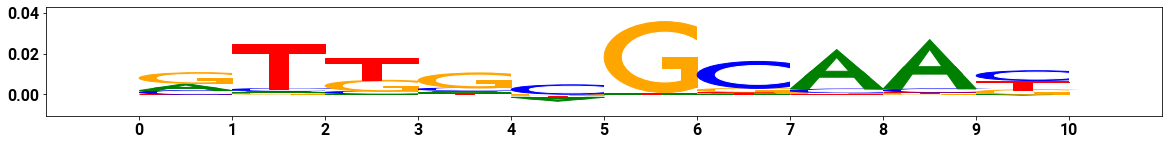

In [10]:
viz_sequence.plot_weights(cwms[motif_key])

chr8:28945367-28945377


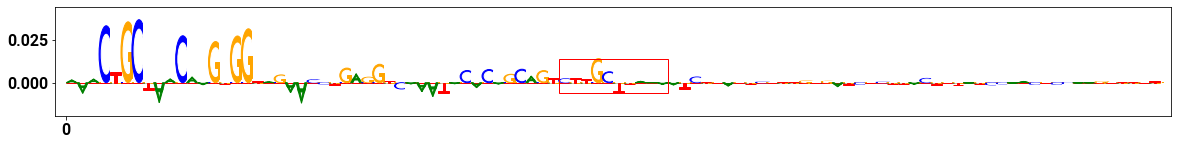

CTTGCTTAAA
chr12:53686257-53686267


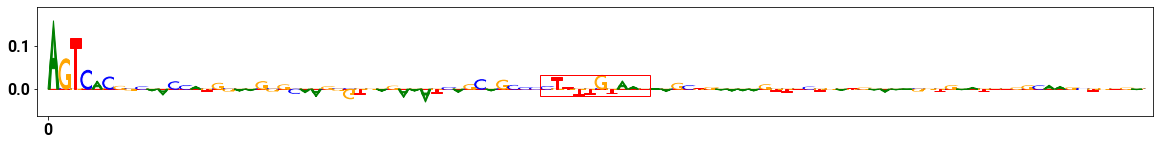

CTTTTGTAAT
chr17:1611880-1611890


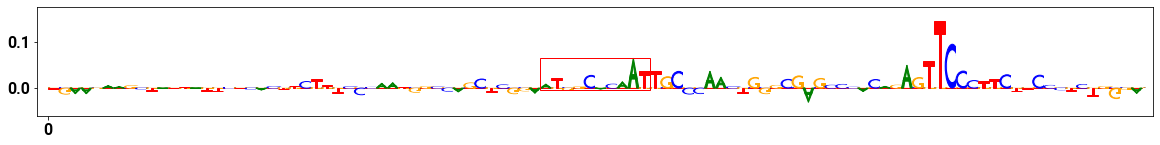

ATGGCACAAT
chr1:203955072-203955082


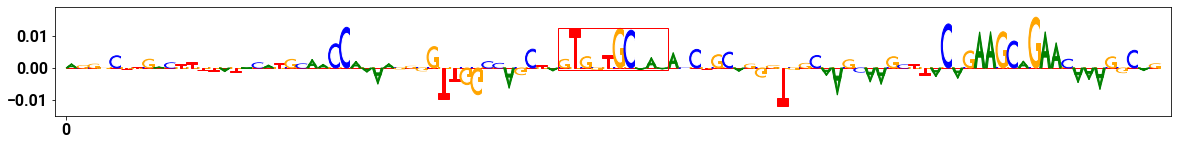

GTGGTGCAAA
chr8:17390784-17390794


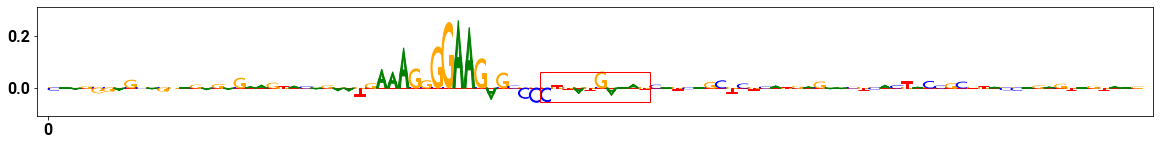

CTTATGAAAT
chr2:11543514-11543524


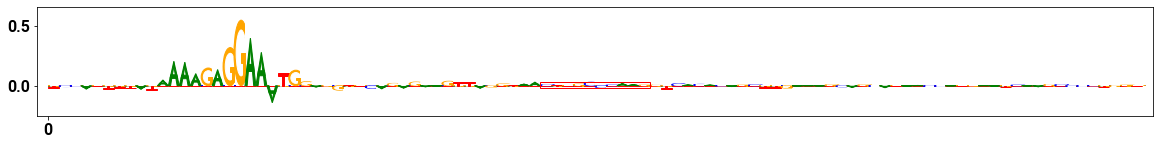

CTTGCCCAAG
chr7:42278588-42278598


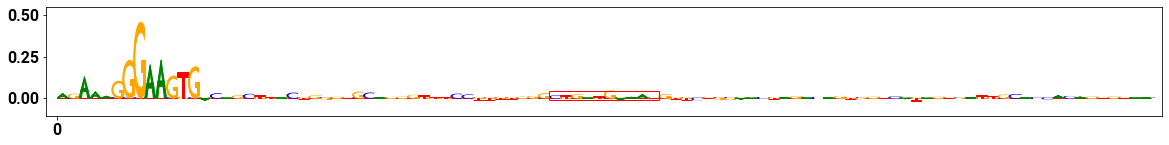

CTGATGAAAT
chr18:10094845-10094855


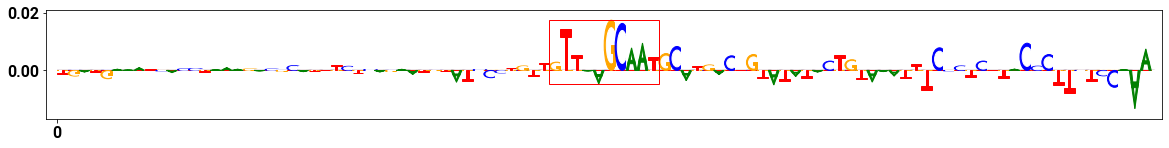

GTTAAGCAAT
chr9:36169900-36169910


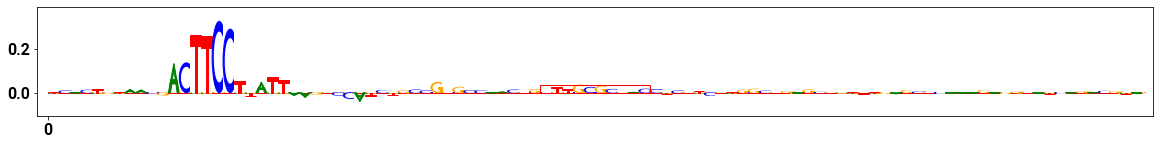

CTTGCGCTAC
chr7:114554891-114554901


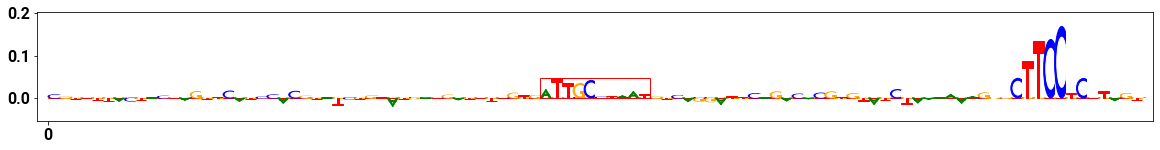

ATTGCCTAAT
chr6:25612754-25612764


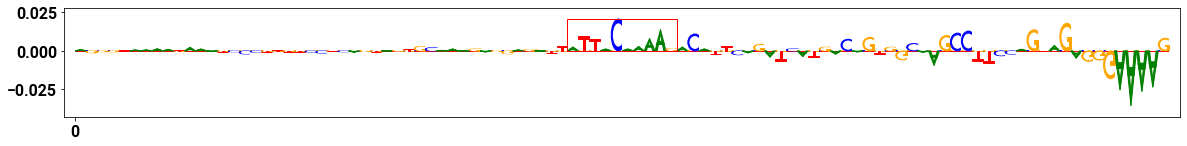

ATTACAAAAG
chr6:56734567-56734577


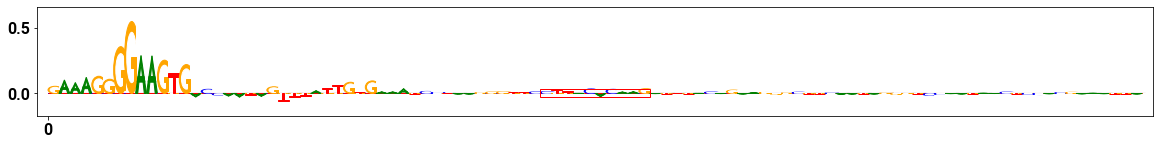

CTTACACAAG
chr4:137705685-137705695


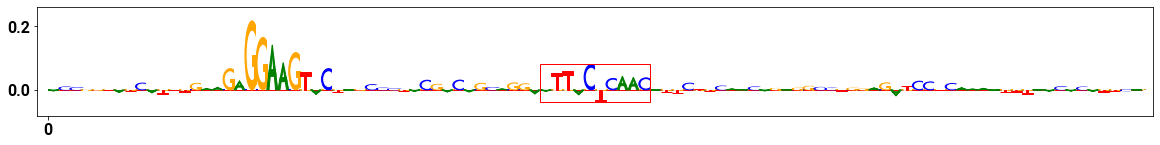

ATTACTCAAC
chr11:121448805-121448815


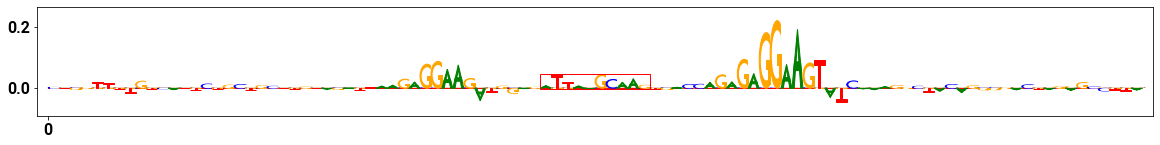

ATTAAGCAAG
chr6:158653109-158653119


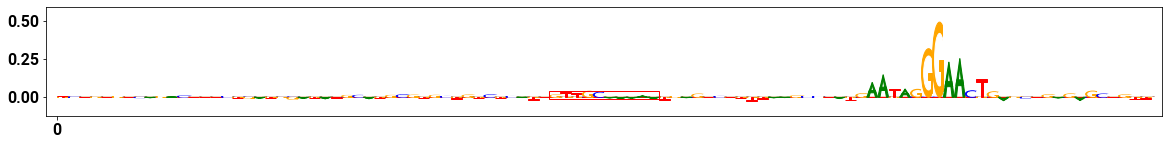

GTTGCAAAAA
chr6:28945507-28945517


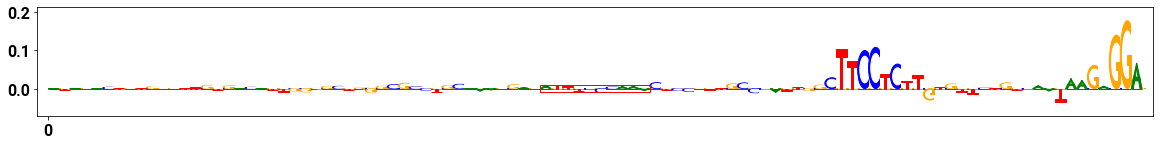

ATTTCCCAAA
chr7:5680306-5680316


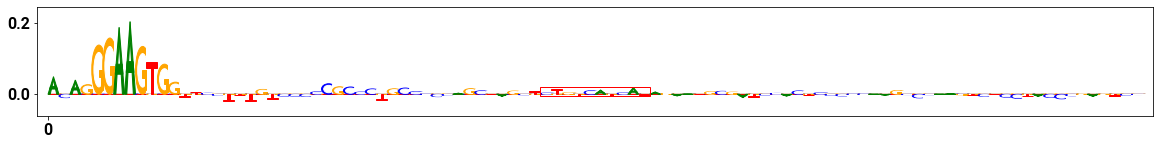

CTGTCATCAT
chr6:87902541-87902551


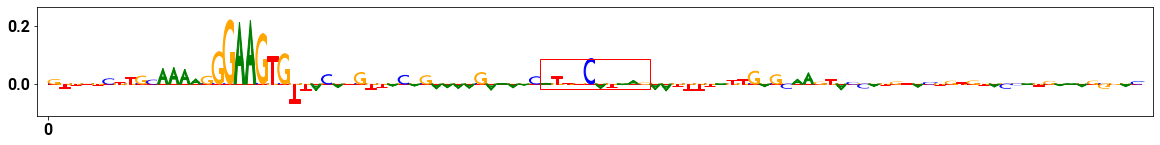

ATTTCATAAG
chr6:105824707-105824717


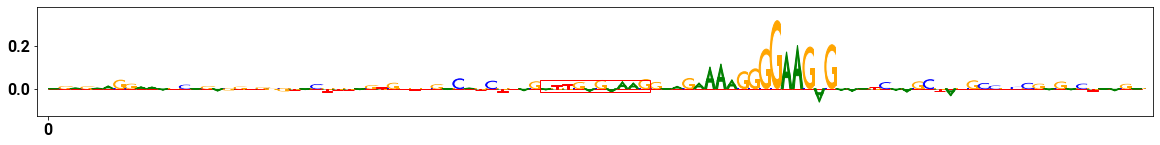

ATTGAGAAAG
chr16:1840053-1840063


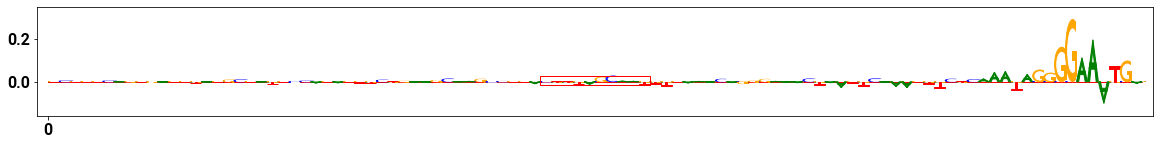

CTTTAGCAAT


In [11]:
# Show some examples of sequences with motif hits
num_to_show = 20
score_center_size = 100

match_hits = hit_table[hit_table["key"] == motif_key].sample(num_to_show, replace=False)

for _, row in match_hits.iterrows():
    chrom, start, end = row[["chrom", "start", "end"]]
    print("%s:%d-%d" % (chrom, start, end))
    
    mid = (start + end) // 2
    score_start = mid - (score_center_size // 2)
    score_end = score_start + score_center_size
    
    # Match to DeepSHAP score track
    mask = (shap_coords[:, 0] == chrom) & (shap_coords[:, 1] <= score_start) & (shap_coords[:, 2] >= score_end)
    if not np.sum(mask):
        print("No matching input sequence found")
    shap_index = np.where(mask)[0][0]  # Pick one
    
    _, coord_start, coord_end = shap_coords[shap_index]
    imp_scores = act_scores[shap_index]
    one_hot_seq = one_hot_seqs[shap_index]
    
    cut_start = score_start - coord_start
    cut_end = cut_start + score_center_size
    imp_scores = imp_scores[cut_start:cut_end]
    one_hot_seq = one_hot_seq[cut_start:cut_end]
    
    seq = one_hot_to_seq(one_hot_seq)
    
    hit_rel_start = max(row["start"] - score_start, 0)
    hit_rel_end = min(row["end"] - score_start, score_center_size)
    highlights = {"red": [(hit_rel_start, hit_rel_end)]}

    viz_sequence.plot_weights(
        imp_scores, subticks_frequency=(len(imp_scores) + 1), highlight=highlights
    )
    plt.show()
    print(seq[hit_rel_start:hit_rel_end])